# A quanvolutional neural network

Author: Mack, Mohammad

This tutorial demonstrates a basic quantum-enhanced neural network. Called a _quanvolutional neural network_, this is an enhanced machine learning model introduced in Henderson et al. (2019). Modifications from the original tutorial include easier customization, the addition of the classical convolution layer in the classical model (skipped in the original), and the implementation of a fully quantum neural network with quantum variational circuit nets. Tensorflow will be used for the classical layers.

The layers used is only to demonstrate the potential strengths of a quantum convolutional layer, even if the layer is not trainable. Much better optimized layers exist for the classification of MNIST, which can show potential of further improvement when certain conventional layers are replaced with quantum layers.

## Prerequisite: Importing libraries

We will use Tensorflow as our machine learning library. Pennylane, as `qml`, contains its own version of `numpy` packages. Additionally, you may have to use a "downdated" version of Python, namely Python 3.9, so it is compatible with `tensorflow-quantum`. The libraries that are required are:

* `pennylane`
* `tensorflow`
* `matplotlib`

Failing to import all the packages will result in an ImportError.

In [28]:
# Import Pennylane libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

# Import Tensorflow
import tensorflow as tf
from tensorflow import keras

# Import Matplotlib
import matplotlib.pyplot as plt

print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Set up dataset and hyperparameters

The deep learning model consists of a convolutional layer (ran both classically and quantumly), using a random kernel of a given size, and pooling. The hyperparameters used will be:

* $K$, the dimension of the square kernel
* $L$, the number of layers of the kernel

In [29]:
# Convolution
n_channels = 8                  # Number of random channels
kernel_size = 3                 # Size of kernel

# Epochs
n_epochs = 500                  # Number of optimization epochs
n_train = 512                   # Size of the train dataset
n_test = 256                    # Size of the test dataset
batch_size = 16

# Dataset
SAVE_PATH = "./mnist"           # Data saving folder
PREPROCESS = True               # If False, skip quantum processing and load data from SAVE_PATH
SETSEED = False
if SETSEED:
    np.random.seed(0)           # Seed for NumPy random number generator
    tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# Dataset and image size
DATASET = keras.datasets.mnist # Default dataset
(train_images, train_labels), (test_images, test_labels) = DATASET.load_data() # Load data (returns a pair of image-label pairs)
HEIGHT = 28
LENGTH = 28
LABELS = 10                # Units of dense second layer

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

## Quantum circuit

In a quantum convolutional network, the convolutional kernel is a quantum circuit. The orderings of the gate operations become one quanvolutional filter in the quanvolutional layer. A _random_ quantum convolutional filter is used, described using $LK^2$ parameters.

[[3.50779896 6.16532764 1.22920675]
 [2.86781936 6.10704605 2.07261627]
 [0.58338584 1.17890749 3.71982737]]
[[4.25977905 0.98765466 5.44181169]
 [1.67463014 2.56574163 4.75183005]
 [2.1186486  5.4482366  2.00967673]]
[[2.24192145 1.88534557 1.47530241]
 [2.90370613 4.30701848 6.25081607]
 [5.84419111 4.33054943 5.384125  ]]
[[2.05667771 5.90186121 5.00118399]
 [6.02356859 2.74411123 1.27180563]
 [1.20689385 1.25759618 6.20141104]]
[[3.47891261 4.84567028 2.53179109]
 [2.59311513 4.16417199 5.99340356]
 [6.20355975 2.70638636 1.95150978]]
[[6.03761033 3.81516189 6.04176675]
 [5.25815399 0.27219055 4.81273581]
 [5.91434789 0.51077831 0.66662095]]
[[5.08550955 3.32947345 2.99717612]
 [5.53725545 5.60847653 1.2461397 ]
 [5.81926919 6.09895229 2.65060709]]
[[1.70886919 5.87351948 0.16867162]
 [4.71724244 5.1361158  3.56244836]
 [2.80497178 2.77798896 3.50725493]]


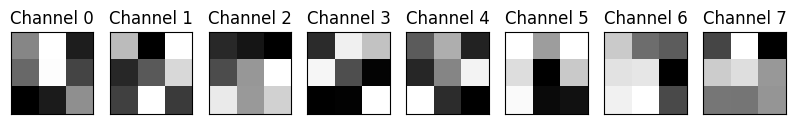

In [30]:
# Quantum circuit as a convolution kernel

dev = qml.device("default.qubit", wires=kernel_size*kernel_size+1)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_channels, kernel_size*kernel_size))
rand_params # A L × K² tensor

fig, axes = plt.subplots(1, n_channels, figsize=(10, 10))
for k in range(n_channels):
    axes[k].set_title("Channel {0:d}".format(k))
    axes[k].xaxis.set_visible(False)
    axes[k].yaxis.set_visible(False)
    print(rand_params[k].reshape([kernel_size,kernel_size]))
    axes[k].imshow(rand_params[k].reshape([kernel_size,kernel_size]), cmap="gray") # Lighter indicate higher value


### Circuit implementation

The quantum circuit will be the convolutional and pooling layer. For each channel and pixel, the circuit consists of $K^2$ qubit wires, with each wire representing a particular neighboring cell used for the pixel. The inputs of the convolutional filter is passed through a RY gate, and the entire circuit is operated by a RandomLayer described by `rand_params`.

/tmp/ipykernel_37673/3304533466.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


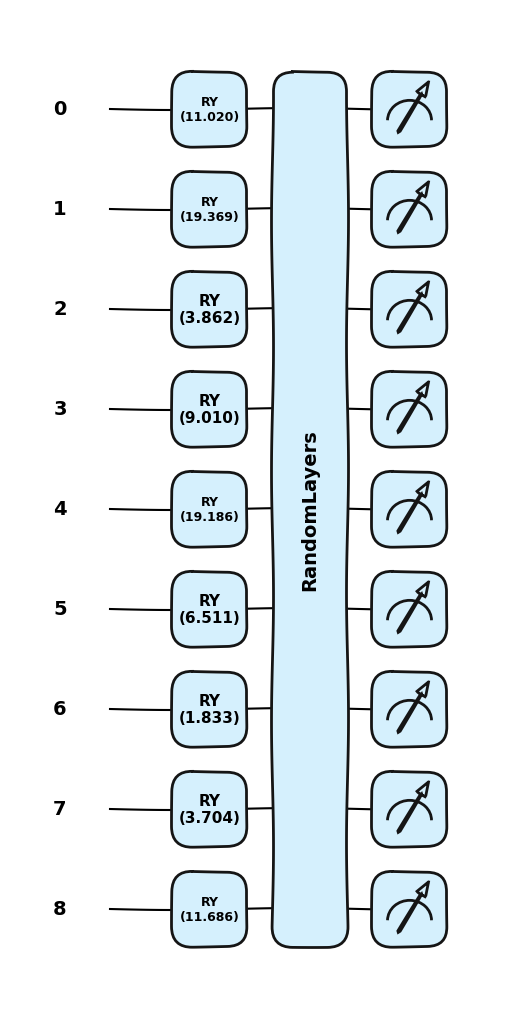

In [31]:
# Develop quantum circuit

@qml.qnode(dev)
def circuit(phi):
    # Encoding of classical input values from kernel
    for wire in range(kernel_size*kernel_size):
        qml.RY(np.pi * phi[wire], wires=wire)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(kernel_size*kernel_size)))

    # Measurement producing classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(kernel_size*kernel_size)]

def generatefilter(image, j, k):
    """Lists out the neighboring cells useed for this convolution"""
    filter = []
    for j1 in range(0, kernel_size):
        for k1 in range(0, kernel_size):
            filter.append(image[j + j1, k + k1, 0])
    return filter

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((HEIGHT//kernel_size, LENGTH//kernel_size, kernel_size*kernel_size))

    # Loop over the coordinates of the top-left pixel of squares
    for j in range(0, HEIGHT - kernel_size + 1, kernel_size):
        for k in range(0, LENGTH - kernel_size + 1, kernel_size):
            # Process a squared region of the image with a quantum circuit
            q_results = circuit(generatefilter(image, j, k))
            # Assign expectation values to different channels of the output pixel as pooling layer
            for c in range(kernel_size*kernel_size):
                out[j // kernel_size, k // kernel_size, c] = q_results[c]
    return out

# Sketch out demo circuit
democircuit = circuit(generatefilter(test_images[0], 0, 0))
drawer = qml.draw_mpl(circuit, style='pennylane_sketch', decimals=3)
fig, ax = drawer(rand_params[0])
fig.show()

## Manual Quantum layer

In the hybrid model, the only quantum step is the quantum preprocessing of trained images. This step is skipped for the classical convolutional algorithm.

In [32]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
512/512        
Quantum pre-processing of test images:


### Displaying quantum convolution and pooling.

The following code is a demonstration of applying the quantum convolutional and pooling layer.

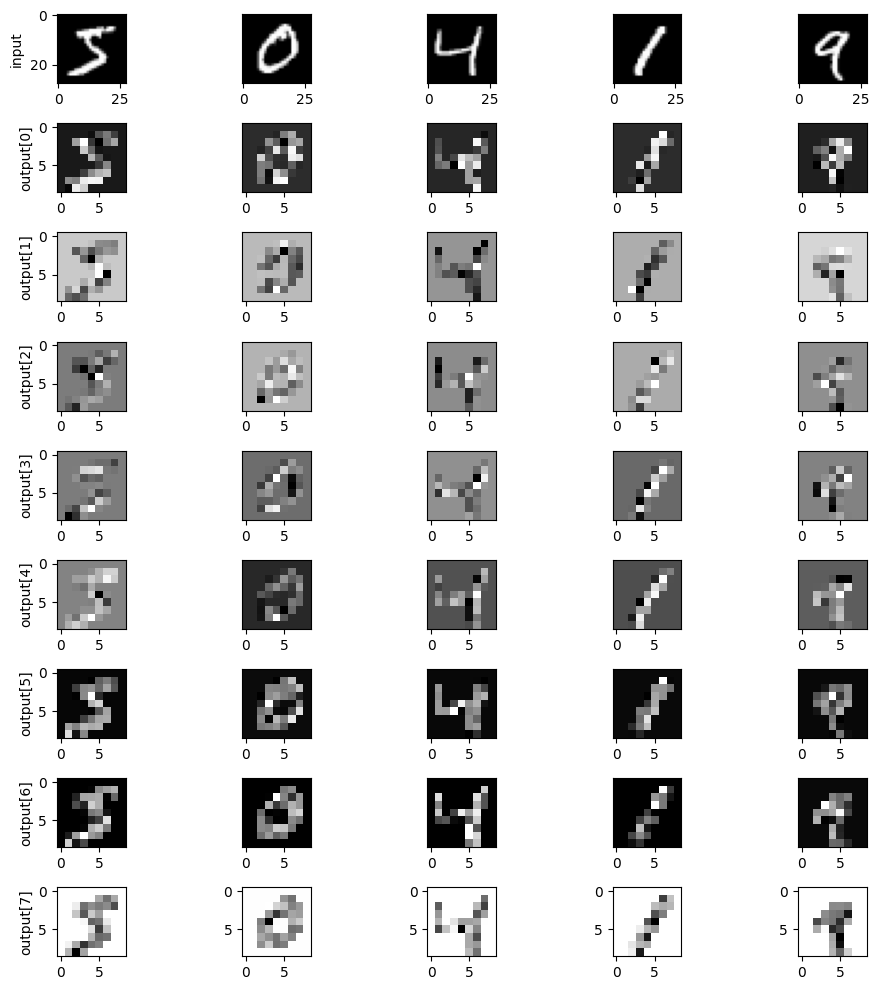

In [33]:
DISPLAYSAMPLES = 5
fig, axes = plt.subplots(1 + n_channels, DISPLAYSAMPLES, figsize=(10, 10))
# Column number is the sample used
for k in range(DISPLAYSAMPLES):
    # Plot input channel
    axes[0, 0].set_ylabel("input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("output[{}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")
plt.tight_layout()
plt.show()

## Set Model

The remaining part of the model contains a flattening layer and a dense neural network of width 10, with softmax activation. For the conventional run, a comparable non-trainable random convolutional kernel is used.

In [34]:
convseq = keras.models.Sequential([
		keras.layers.Conv2D(n_samples, kernel_size, activation=None, strides=kernel_size, trainable=False),
        keras.layers.Flatten(),
        keras.layers.Dense(LABELS, activation="softmax")
])

flattenonly = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(LABELS, activation="softmax")
])

def MyModel(model):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Classical

The model only uses the conventional image training preprocessing layer.

In [35]:
c_model = MyModel(convseq)

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/500
32/32 - 2s - 56ms/step - accuracy: 0.2090 - loss: 2.2463 - val_accuracy: 0.3008 - val_loss: 2.1969
Epoch 2/500
32/32 - 0s - 4ms/step - accuracy: 0.5098 - loss: 2.0798 - val_accuracy: 0.4492 - val_loss: 2.0801
Epoch 3/500
32/32 - 0s - 4ms/step - accuracy: 0.6348 - loss: 1.9326 - val_accuracy: 0.5195 - val_loss: 1.9767
Epoch 4/500
32/32 - 0s - 5ms/step - accuracy: 0.7227 - loss: 1.7988 - val_accuracy: 0.5781 - val_loss: 1.8793
Epoch 5/500
32/32 - 0s - 4ms/step - accuracy: 0.7500 - loss: 1.6781 - val_accuracy: 0.6016 - val_loss: 1.7902
Epoch 6/500
32/32 - 0s - 4ms/step - accuracy: 0.7637 - loss: 1.5700 - val_accuracy: 0.6016 - val_loss: 1.7092
Epoch 7/500
32/32 - 0s - 4ms/step - accuracy: 0.7852 - loss: 1.4723 - val_accuracy: 0.6133 - val_loss: 1.6377
Epoch 8/500
32/32 - 0s - 4ms/step - accuracy: 0.7949 - loss: 1.3844 - val_accuracy: 0.6133 - val_loss: 1.5689
Epoch 9/500
32/32 - 0s - 3ms/step - accuracy: 0.8066 - loss: 1.3053 - val_accuracy: 0.6328 - val_loss: 1.5097
Epoch 10/

## Hybrid Quantum

In [36]:
q_model = MyModel(flattenonly)

q_history = q_model.fit(
    q_train_images, # Preprocessed
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/500
32/32 - 1s - 41ms/step - accuracy: 0.2129 - loss: 2.2161 - val_accuracy: 0.3281 - val_loss: 2.1164
Epoch 2/500
32/32 - 0s - 5ms/step - accuracy: 0.4570 - loss: 1.9980 - val_accuracy: 0.3906 - val_loss: 1.9655
Epoch 3/500
32/32 - 0s - 5ms/step - accuracy: 0.5645 - loss: 1.8159 - val_accuracy: 0.5391 - val_loss: 1.8413
Epoch 4/500
32/32 - 0s - 4ms/step - accuracy: 0.6621 - loss: 1.6660 - val_accuracy: 0.5391 - val_loss: 1.7252
Epoch 5/500
32/32 - 0s - 4ms/step - accuracy: 0.6816 - loss: 1.5214 - val_accuracy: 0.6562 - val_loss: 1.6330
Epoch 6/500
32/32 - 0s - 4ms/step - accuracy: 0.7969 - loss: 1.4108 - val_accuracy: 0.6680 - val_loss: 1.5383
Epoch 7/500
32/32 - 0s - 4ms/step - accuracy: 0.7734 - loss: 1.3031 - val_accuracy: 0.6602 - val_loss: 1.4732
Epoch 8/500
32/32 - 0s - 4ms/step - accuracy: 0.8125 - loss: 1.2128 - val_accuracy: 0.6914 - val_loss: 1.4020
Epoch 9/500
32/32 - 0s - 4ms/step - accuracy: 0.8184 - loss: 1.1336 - val_accuracy: 0.7070 - val_loss: 1.3381
Epoch 10/

## Quantum

This is a fully quantum implementation of the quanvolutional neural network, using a variational circuit.

In [23]:
dev2 = qml.device("default.qubit", wires=LABELS)

@qml.qnode(dev2)
def variational_circuit(params, flattened):
    parameters = params.reshape((10, 4, 3))
    qml.templates.StronglyEntanglingLayers(parameters, wires=range(LABELS))
    return qml.expval(qml.Hermitian(hamiltonian, wires = [0,1]))
	
def optimize_circuit(params, flattened):
    i_params = params # Initial guess parameters
    cost = circuit(params, flattened)
    opt = qml.GradientDescentOptimizer(stepsize=1) # Our optimizer!

    ITERATIONS = 1000 # Maximum number of calls to the optimizer 
    TOLERANCE = 0.01 # Convergence threshold to stop our optimization procedure
    
    for n in range(ITERATIONS):
        [i_params, hamiltonian], prev_cost = opt.step_and_cost(circuit, i_params, hamiltonian)
        cost = circuit(i_params, hamiltonian)
        conv = np.abs(cost - prev_cost)
        # print(i_params)
        # print(hamiltonian)
        # print(prev_cost, cost)
        # print()
    
    return circuit(i_params, hamiltonian) # Return the value of the minimized QNode

# Run circuit
ins = np.array(json.loads(test_case_input), requires_grad = False)
hamiltonian = np.array(ins,float).reshape((2 ** WIRES), (2 ** WIRES))
np.random.seed(1967)
initial_params = np.random.random(NUM_PARAMETERS)


NameError: name 'json' is not defined

## Graph results

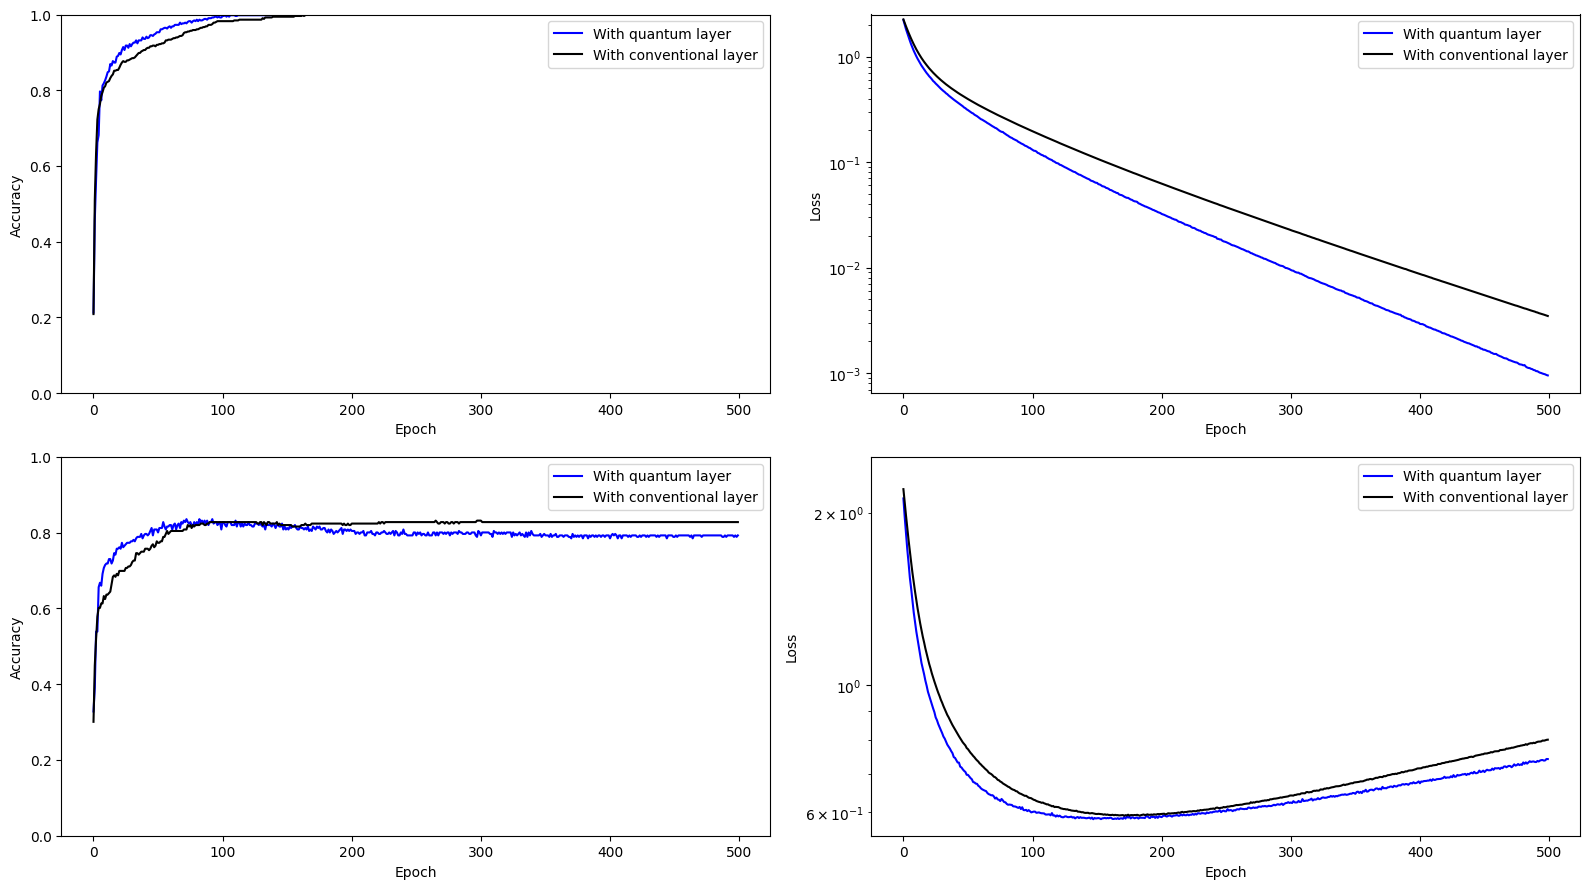

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))

ax1.plot(q_history.history["accuracy"], "-b", label="With quantum layer")
ax1.plot(c_history.history["accuracy"], "-k", label="With conventional layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["loss"], "-b", label="With quantum layer")
ax2.plot(c_history.history["loss"], "-k", label="With conventional layer")
ax2.set_yscale("log")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

ax3.plot(q_history.history["val_accuracy"], "-b", label="With quantum layer")
ax3.plot(c_history.history["val_accuracy"], "-k", label="With conventional layer")
ax3.set_ylabel("Accuracy")
ax3.set_ylim([0, 1])
ax3.set_xlabel("Epoch")
ax3.legend()

ax4.plot(q_history.history["val_loss"], "-b", label="With quantum layer")
ax4.plot(c_history.history["val_loss"], "-k", label="With conventional layer")
ax4.set_yscale("log")
ax4.set_ylabel("Loss")
ax4.set_ylim(top=2.5)
ax4.set_xlabel("Epoch")
ax4.legend()

plt.tight_layout()
plt.show()

## Discussion

